In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
import jax_smi
jax_smi.initialise_tracking()

In [4]:
filename = "models/phi-3-16.gguf"
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")

In [5]:
from micrlhf.utils.vector_storage import download_vector
layer = 20

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
tokenizer.padding_side = "right"

In [7]:
from micrlhf.utils.mmlu_eval import MMLUEval
mmlu_eval = MMLUEval(use_truthfulqa=True)

In [8]:
resids = mmlu_eval.get_resids(llama, tokenizer, layer)

  0%|          | 0/2052 [00:00<?, ?it/s]

  0%|          | 0/684 [00:00<?, ?it/s]

In [9]:
from micrlhf.utils.load_sae import get_sae
from sklearn.metrics import roc_auc_score
import numpy as np
from matplotlib import pyplot as plt

def eval_mmlu(feat):
    if feat is None:
        vector_name = "phi3-sycophancy-l20"
        vector = download_vector(vector_name, overwrite=True)
    elif isinstance(feat, tuple):
        vector_name = f"phi3-sycophancy-l{feat[0]}-recon-r{feat[1]}"
        vector = download_vector(vector_name, overwrite=True)
    else:
        vector_name = f"l20r5 feature {feat}"
        vector = get_sae(20, 5)["W_dec"][feat]
    x = [[], []]
    for vec, correct in resids:
        x[correct].append(float(vec @ vector))
    incorrect = np.asarray(x[0])
    correct = np.asarray(x[1])
    # thresholds = np.linspace(-100, 100, 1000)
    labels = [np.ones_like(correct), np.zeros_like(incorrect)]
    roc_auc = max(roc_auc_score(np.concatenate(labels), np.concatenate([correct * s, incorrect * s])) for s in (1, -1))
    return roc_auc, x, vector_name


--2024-08-22 22:48:25--  https://huggingface.co/nev/phi-3-4k-saex-test/resolve/main/l20-test-run-5-7.00E-06/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.74, 108.157.142.55, 108.157.142.50, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.74|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/eb/d8/ebd889d6ac58573e8e8a7aa1176d4d357581a6da60135b94aca378fddf4e9e54/83ac196e9d76d5a3db26b4cc47737ff5c79d3cba0ce3954d02283b9331464948?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1724626105&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNDYyNjEwNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2ViL2Q4L2ViZDg4OWQ2YWM1ODU3M2U4ZThhN2FhMTE3NmQ0ZDM1NzU4MWE2ZGE2MDEzNWI5NGFjYTM3OGZkZGY0ZTllNTQvODNhYzE5NmU5

l20r5 feature 9999: 0.6115740607766544


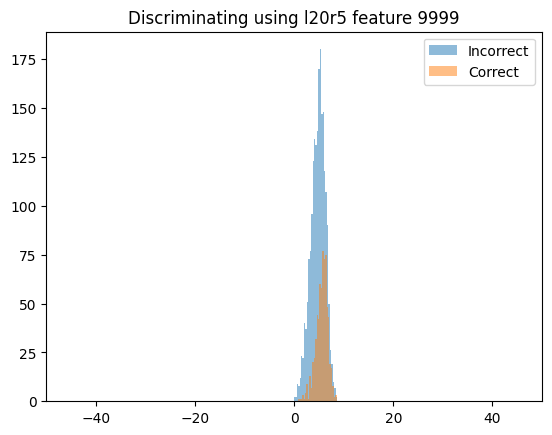

l20r5 feature 42: 0.5345710305606617


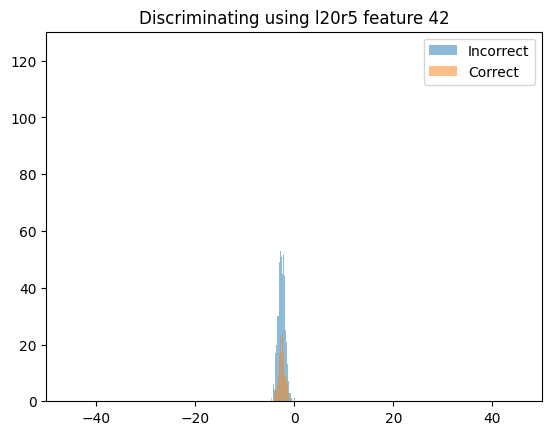

l20r5 feature 45142: 0.6252596986060049


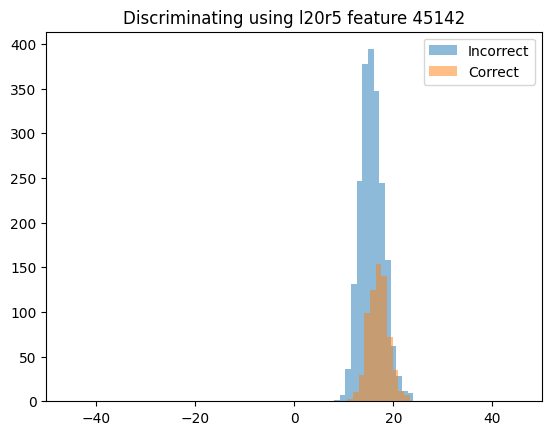

l20r5 feature 15036: 0.6530743767233456


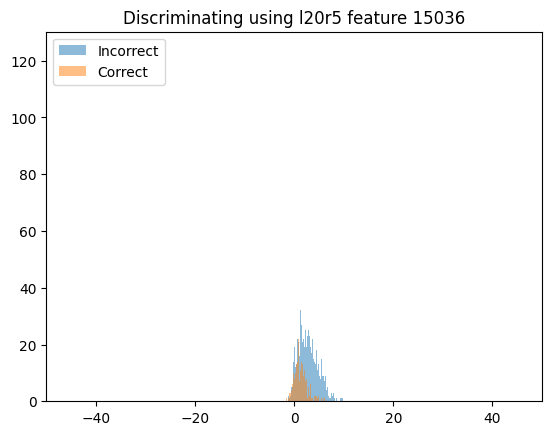

phi3-sycophancy-l20-recon-r5: 0.6623415479473038


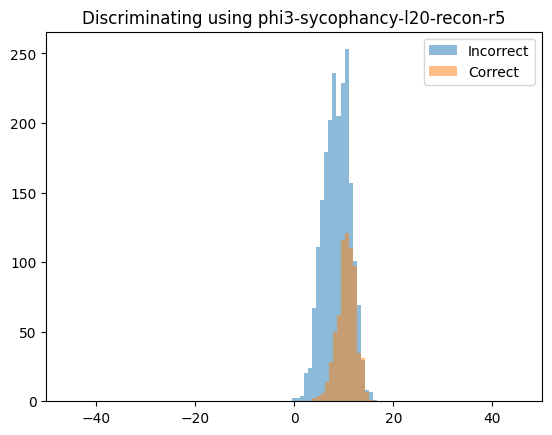

phi3-sycophancy-l20: 0.7401242723651961


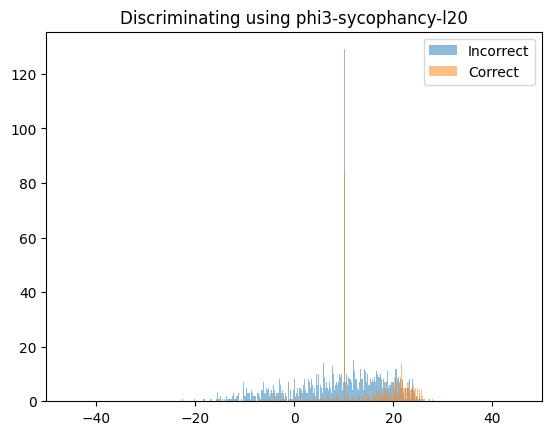

In [10]:

for feat in (9999, 42, 45142, 15036, (20, 5), None):
    roc_auc, x, vector_name = eval_mmlu(feat)
    print(f"{vector_name}:", roc_auc)
    plt.title(f"Discriminating using {vector_name}")
    plt.xlim(-50, 50)
    plt.hist(x[0], bins=500, alpha=0.5, label="Incorrect")
    plt.hist(x[1], bins=500, alpha=0.5, label="Correct")
    plt.legend()
    plt.show()

In [11]:
import numpy as np
w_dec = np.asarray(get_sae(20, 5)["W_dec"])
resids_cpu = [[np.asarray(x), y] for x, y in resids]
def eval_mmlu_fast(feat):
    vector = w_dec[feat]
    x = [[], []]
    for vec, correct in resids_cpu:
        x[correct].append(float(vec @ vector))
    incorrect = np.asarray(x[0])
    correct = np.asarray(x[1])
    # thresholds = np.linspace(-100, 100, 1000)
    labels = [np.ones_like(correct), np.zeros_like(incorrect)]
    roc_auc = max(roc_auc_score(np.concatenate(labels), np.concatenate([correct * s, incorrect * s])) for s in (1, -1))
    return roc_auc


In [12]:
from tqdm.auto import trange
roc_aucs = []
for feat in trange(len(w_dec)):
    roc_auc = eval_mmlu_fast(feat)
    roc_aucs.append(roc_auc)

  0%|          | 0/49152 [00:00<?, ?it/s]

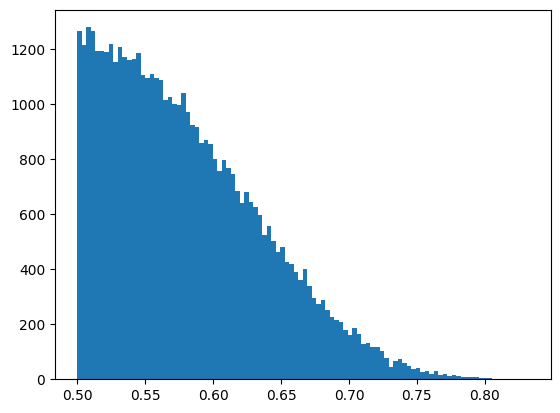

In [13]:
plt.hist(roc_aucs, bins=100)
plt.show()

In [14]:
(np.asarray(roc_aucs) >= 0.7099).sum()

1238

In [15]:
feats = np.nonzero((np.asarray(roc_aucs) >= 0.7099))[0].tolist()
sorted(feats, key=lambda x: roc_aucs[x], reverse=True)

[21870,
 28105,
 37547,
 7849,
 38816,
 33826,
 9906,
 16650,
 17508,
 16808,
 15516,
 43860,
 26536,
 21417,
 2171,
 28684,
 26761,
 15114,
 34447,
 15880,
 10952,
 33521,
 34966,
 11151,
 27792,
 10238,
 18045,
 41447,
 18770,
 3676,
 31915,
 12602,
 32384,
 37144,
 34555,
 27416,
 27865,
 5598,
 14011,
 10436,
 44134,
 3487,
 33286,
 9408,
 2358,
 38494,
 30126,
 45320,
 5169,
 38275,
 47170,
 13932,
 34142,
 10778,
 14082,
 43511,
 24196,
 28265,
 46002,
 5976,
 28526,
 26236,
 28578,
 19622,
 22401,
 15596,
 25743,
 20412,
 3945,
 45449,
 27380,
 2992,
 8355,
 42480,
 6828,
 3873,
 12450,
 1979,
 42215,
 11730,
 41477,
 33833,
 11043,
 39535,
 30499,
 15122,
 33401,
 18518,
 29559,
 12967,
 47548,
 36664,
 11149,
 26936,
 48940,
 10590,
 27235,
 5594,
 3253,
 35020,
 23275,
 20937,
 20616,
 14518,
 8934,
 21727,
 45204,
 14207,
 34357,
 10680,
 33817,
 43018,
 36759,
 22581,
 22608,
 34884,
 1054,
 38786,
 41443,
 44497,
 5069,
 44846,
 3909,
 10741,
 43123,
 22510,
 14058,
 6773,
 11282,
 41816,
 6140,
 13994,
 18364,
 8465,
 32453,
 2207,
 236,
 2302,
 4246,
 7200,
 47224,
 47812,
 13818,
 31947,
 33703,
 35506,
 7414,
 3202,
 16911,
 37227,
 30159,
 28960,
 46548,
 24345,
 27125,
 33403,
 259,
 3857,
 6254,
 11646,
 24843,
 30449,
 30960,
 28860,
 29026,
 5413,
 3697,
 2041,
 23613,
 27996,
 48430,
 15904,
 6221,
 10752,
 32153,
 26125,
 28821,
 3091,
 7803,
 31174,
 2234,
 38519,
 25893,
 18508,
 39860,
 16696,
 3766,
 7545,
 47027,
 37853,
 48020,
 11713,
 37046,
 13386,
 22260,
 26473,
 18771,
 27252,
 35970,
 10717,
 25329,
 24271,
 24327,
 11643,
 8866,
 20788,
 33324,
 43357,
 29637,
 45256,
 22568,
 14895,
 40707,
 35914,
 11301,
 46668,
 4977,
 12533,
 4696,
 26408,
 25475,
 17294,
 42087,
 5589,
 41962,
 23452,
 37045,
 10345,
 42330,
 28267,
 41682,
 48249,
 14658,
 5633,
 23179,
 6891,
 48777,
 42253,
 4597,
 20743,
 13993,
 27474,
 48733,
 5290,
 9467,
 36510,
 39499,
 29836,
 30277,
 23567,
 43147,
 27875,
 26896,
 5642,
 344,
 26841,
 33977,
 32884,
 23672,
 44804,
 19347,
 8870,
 37025,
 29556,
 29368,
 10755,
 25327,
 7273,
 39192,
 29165,
 10062,
 13308,
 13902,
 34053,
 20601,
 33469,
 48629,
 27793,
 39687,
 28237,
 9039,
 36368,
 41436,
 26744,
 22867,
 34305,
 20184,
 10678,
 21084,
 7131,
 32869,
 47634,
 27009,
 40454,
 20999,
 24976,
 44746,
 38827,
 34303,
 30096,
 14194,
 43708,
 16182,
 22061,
 8749,
 32739,
 30988,
 35134,
 21941,
 40095,
 30587,
 23749,
 38951,
 15668,
 40382,
 48892,
 38018,
 31046,
 28288,
 47126,
 54,
 43190,
 7362,
 5529,
 1587,
 46000,
 4027,
 43783,
 44551,
 31373,
 46311,
 17525,
 2339,
 43706,
 1277,
 25172,
 4455,
 42655,
 46782,
 46807,
 25336,
 45894,
 44168,
 10142,
 41486,
 18013,
 23263,
 23942,
 23138,
 35986,
 39175,
 42962,
 40897,
 45641,
 22926,
 6089,
 36344,
 44484,
 37081,
 39060,
 23772,
 9538,
 41605,
 46840,
 8282,
 29135,
 13666,
 20763,
 20623,
 27567,
 17736,
 27369,
 25552,
 19832,
 14140,
 47664,
 33699,
 36608,
 17234,
 34902,
 279,
 46864,
 30006,
 26318,
 8428,
 14109,
 4351,
 20262,
 20493,
 47642,
 43337,
 43625,
 43290,
 42725,
 47942,
 15850,
 4186,
 43799,
 10645,
 20527,
 37065,
 47726,
 11226,
 12009,
 21823,
 35402,
 37197,
 22816,
 9318,
 4080,
 48012,
 1786,
 13615,
 29860,
 24095,
 16142,
 1438,
 19057,
 42123,
 33114,
 40289,
 14087,
 26015,
 41492,
 23311,
 45639,
 13710,
 15635,
 29207,
 31708,
 4698,
 27181,
 43864,
 15606,
 21470,
 37623,
 21234,
 28391,
 8462,
 25431,
 1410,
 16567,
 34191,
 9662,
 7139,
 28286,
 8737,
 47466,
 46190,
 33301,
 34888,
 35035,
 94,
 39497,
 9554,
 18093,
 12024,
 42173,
 32743,
 24243,
 6069,
 25189,
 4809,
 46152,
 6360,
 12185,
 47776,
 15999,
 28060,
 37386,
 35388,
 13238,
 45954,
 28397,
 32082,
 7626,
 25009,
 29891,
 2218,
 41142,
 22499,
 4024,
 35888,
 32357,
 41139,
 31187,
 18146,
 14982,
 12549,
 11556,
 30037,
 26973,
 10598,
 18623,
 30309,
 46238,
 42750,
 48755,
 25544,
 35542,
 36426,
 14849,
 14008,
 30417,
 21337,
 44865,
 24553,
 44906,
 46744,
 39097,
 8017,
 25652,
 20738